In [16]:
from pathlib import Path
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

bqp_error=0.4
with Path("../../circuits/table.json").open() as f:
    table = json.load(f)
    circuits = [name for name, prob in table.items() if prob < bqp_error or prob > 1-bqp_error]
    # prob = prob of having 1
    # prob < $bqp_error$ => No instance
    # print(len(circuits))

bqp_error = 0.4
def find_correct_value(circuit_name):
    with Path("../../circuits/table.json").open() as f:
        table = json.load(f)
        # return 1 if yes instance
        # return 0 else (no instance, as circuits are already filtered)
        # print(table[circuit_name])
        return(int(table[circuit_name] > 1-bqp_error))


print(find_correct_value("circuit489.qasm"))

folder = "../../outcomes-n7-good"
files_dict = {}
for file in os.listdir(folder):
    file_path=os.path.join(folder, file)
    if "raw" not in file_path:
        prob = file.split(".json")[0].split("p")[1]
        files_dict[prob] = file_path
    

0


In [23]:
def get_failure_rate(threshold:float):
    proportion_wrong_outcomes_dict = {}
    for prob in files_dict:
        file_path = files_dict[prob]
        with open(file_path, 'r') as file:
            json_data = json.load(file)

        # Convert JSON data to DataFrame
        df = pd.DataFrame.from_dict(json_data, orient='index')
        df["expected_outcome"] = [find_correct_value(circuit) for circuit in df.index]

        proportion_wrong_outcomes = len(df[(df['outcome'] != df["expected_outcome"]) & (df['failure_rate'] < threshold)])/len(df)
            
        proportion_wrong_outcomes_dict[prob] = proportion_wrong_outcomes
    return proportion_wrong_outcomes_dict

get_failure_rate(threshold=0.05)

{'0.1': 0.23, '0.05': 0.34, '0.18': 0.01, '0.15': 0.05}

In [28]:
import json
import os
import pandas as pd

failure_rates_dict = {}
for prob in files_dict:
    file_path = files_dict[prob]
    with open(file_path, 'r') as file:
        json_data = json.load(file)

    # Convert JSON data to DataFrame
    df = pd.DataFrame.from_dict(json_data, orient='index')
    df["expected_outcome"] = [find_correct_value(circuit) for circuit in df.index]
    df[["outcome_sum",  "n_failed_trap_rounds", "failure_rate", "outcome",  "expected_outcome"]]
    if prob == "0.01":
        print(df)

    trap_round_failure_rate = df["failure_rate"].mean()
    failure_rates_dict[prob] = trap_round_failure_rate


threshold_values = [0.05, 0.07, 0.083, 0.1, 0.15, 0.01]

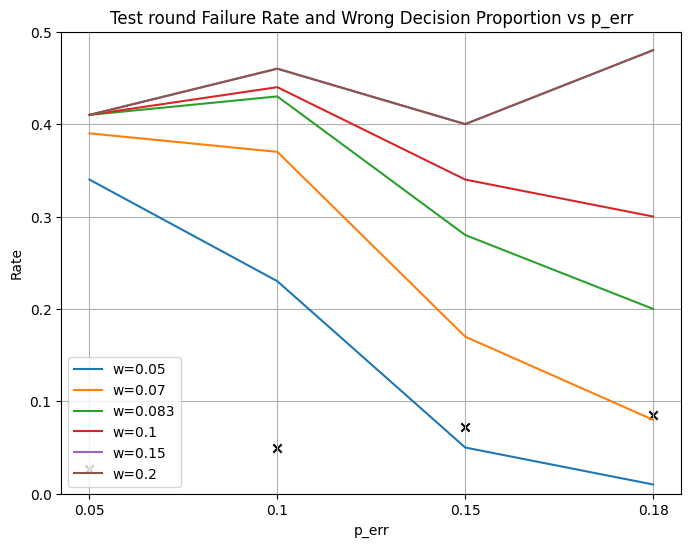

In [29]:
plt.figure(figsize=(8, 6))
p_values = sorted(list(files_dict.keys()))
trap_failure_rates = [failure_rates_dict[prob] for prob in p_values]

for t in threshold_values:
    proportion_wrong_outcomes_dict = get_failure_rate(t)
    comp_failure_rates = [proportion_wrong_outcomes_dict[prob] for prob in p_values]
    plt.plot(p_values, comp_failure_rates, label=f'w={t}')
# wrong_outcomes_rates = [proportion_wrong_outcomes_dict[prob] for prob in p_values]
plt.scatter(x=p_values, y=trap_failure_rates, color="black", marker="x")
# plt.scatter(x=p_values, y=wrong_outcomes_rates, color="red", marker="o")
plt.xlabel("p_err")
plt.ylabel("Rate")
plt.ylim(0, 0.5)
plt.legend()
plt.title("Test round Failure Rate and Wrong Decision Proportion vs p_err")
plt.grid()
plt.show()


Commentaires Harold:
- Test round failure rate
- Le JSON a les infos pertinentes si on garde la proportion de traps echoués 
  - On n'a que la simulation bruitée à faire,
  - et puis on accepte ou on rejette selon le threshold
- Factoriser la simulation "on chip" et "off chip".
  - On va pas faire des simulations différentes, peut-être juste pour le modèle de bruit
  - Laisser dans le protocole le RSP
  - ça met les deux sur le même pied
  - et les discussions sur les deux sont les mêmes, les interprétations sont différentes
  - On fait des simulations dans lesquelles on va, on va les présenter une seule fois, pour l'analyse du protocole dans lequel il y a une RSP qui est parfaite et sécure
  - le off-chip c'est une RSP où qqun prépare un qubit et l'envoie, et les trust assumptions = je m'assure que mon device chez moi produit bien les trucs, et que si ya du bruit alors c bruit indép. du secret
  - Alors le on-chip off-chip on s'en fout de la différence: le noise est secret-independent
  - Dans les deux cas on a montré qu'on a du bruit indépendant du secret.
  - Toute la partie que Cica a ajouté
- Dans le papier:
  1. sur la vérification, on a un protocole template principal fondamental, il fait la vérif :) et àpd ça on va faire un protocole pour benchmark et un protocole pour characterization. Mais dans un premier temps on présente ce protocole, rVBQC.
  2. Pas un protocole pour off-chip, on-chip, mais juste présenter le protocole dans lequel il y a un truc qui s'appelle RSP. On fait les bornes pour ce protocole, les simulations, etc.
     1. analyse theorique
     2. silmulation
  3. Ensuite on se demande comment implémenter ce RSP: 
     1. off-chip (préparation locale + envoi canal quantique ; usuel) 
     2. ou on-chip (envoie de l'instruction chiffrée de manière sécurisée à un ordinateur quantique, et qui l'envoie ensuite dans un canal)
  4. Qu'est-ce que cette différence implique au niveau sécurité ? on regarde dans les cas
     1. off-chip : on prépare localement l'état, puis quantum channel: on fait le calcul puis une CPTP => c'est une trust assumption. faut s'assurer que le device ne fait pas nptq du côté client.
     2. on-chip : Si cette RSP est implémentée chez le serveur, grosso modo on est amené à faire la même trust assumption en fait.